## Модули

In [1]:
import csv
import json
import random
import itertools

import scipy as sp
import numpy as np
import pandas as pd
import networkx as nx
import math
import matplotlib.pyplot as plt
import threading

from fa2 import ForceAtlas2
from matplotlib.pyplot import figure
from typing import Dict, List, Union, Tuple, Set, Any
from copy import deepcopy
from scipy.sparse import csc_matrix

%matplotlib inline

## Данные

Список смежности

In [2]:
with open("friends.json", "r") as f:
    data = json.load(f)
    
adj_list = {int(k): v for k, v in data.items()}

Метки для отрисовки графа

In [3]:
labels = {}

with open("friends.csv", mode="r") as f:
    reader = csv.reader(f)
    labels = {rows[0]:rows[1] for rows in reader}

labels = {int(k): v for k, v in list(labels.items())[1:]}
ego = list(labels.keys())[0]

## Обработка графа

**Список вершин**

In [4]:
def get_nodes(adj_list: Dict[int, List[int]]) -> List[int]:
    vals = list(adj_list.values())
    node_list = set(elem for sub in vals for elem in sub)
    node_list.add(list(adj_list.keys())[0])
    return list(node_list)

**Список рёбер**

In [5]:
def get_edges(adj_list: Dict[int, List[int]]) -> List[Tuple[int, int]]:
    edges = [list(itertools.product([k], v)) for k, v in adj_list.items()]
    flatten = [elem for sub in edges for elem in sub]
    return [(a, b) for a, b in flatten if not ((b, a) in flatten and b > a)]

**Матрица смежности**

In [6]:
def get_adj_matrix(adj_list: Dict[int, List[int]]) -> List[List[int]]:
    nodes = get_nodes(adj_list)
    n = len(nodes)
    matrix = [[0 for j in range(n)] for i in range(n)]
    codes = dict(zip(nodes, range(n)))
    for key, val in adj_list.items():
        for node in val:
            matrix[codes[key]][codes[node]] = 1
            matrix[codes[node]][codes[key]] = 1
    return matrix

In [7]:
g = nx.Graph(adj_list)

## Алгоритмы

__Алгоритм Флойда-Уоршелла__

In [8]:
def adj_floyd_warshall(adj_matrix: List[List[int]]) -> List[List[int]]:
    n = len(adj_matrix)
    new_matrix = deepcopy(adj_matrix)
    
    for i in range(n):
        for j in range(n):
            if new_matrix[i][j] == 0 and i != j:
                new_matrix[i][j] = float("inf")

    return new_matrix

In [9]:
def floyd_warshall(adj_matrix: List[List[int]]):
    n = len(adj_matrix)
    new_matrix = adj_floyd_warshall(adj_matrix)
    dist = list(map(lambda i: list(map(lambda j: j, i)), new_matrix))
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j],
                                 dist[i][k] + dist[k][j])
    return dist

### Network Distribution

__Degree Centrality__

В метрике `Degree Centrality` важность узла определяется тем, с каким количеством узлов он связан. Это измерение количества прямых связей с другими участниками сети. Это означает, что чем больше число смежных узлов, тем важнее узел, поскольку он не зависит от других участников, которые достигают больших частей сети. Это локальная мера, поскольку ее значение рассчитывается на основе количества связей субъекта с другими субъектами, непосредственно примыкающими к нему. Субъекты в социальных сетях с высокой степенью центральности выступают в качестве узлов и основных каналов передачи информации.

$$d(i)=\sum_{j}m_{ij}$$, где $m_{ij}=1$ если есть связь между вершинами $i$ и $j$, $m_{ij}=0$ в противном случае.

In [10]:
def degree_centrality(adj_list: Dict[int, List[int]]) -> Dict[int, int]:
    degree = dict()
    nodes = get_nodes(adj_list)
    edges = get_edges(adj_list)
    for node in nodes:
        degree[node] = 0
        for edge in edges:
            if node in edge:
                degree[node] += 1
    return degree

In [11]:
# degree_centrality(adj_list)

In [12]:
# g.degree()

__Closeness Centrality__

`Closeness Centrality` можно определить как то, насколько близко к определенному субъекту находятся другие субъекты. Это сумма геодезических расстояний узла до всех других узлов сети. Она вычисляет длину путей от одного агента к другим агентам в сети.

$$C(i) = \sum_{j}d_{ij}$$, где $d_{ij}$ это геодезическоре расстояние из узла $i$ в узел $j$.

`Closeness Centrality` важна для понимания распространения информации в сетях в том смысле, что расстояние между одним конкретным узлом и другими влияет на то, как этот узел может получать от других узлов или отправлять им информацию (например, сплетни).

In [13]:
def closeness_centrality(adj_list: Dict[int, List[int]]) -> Dict[int, int]:
    adj_matrix = get_adj_matrix(adj_list)
    fw = floyd_warshall(adj_matrix)
    nodes = get_nodes(adj_list)
    n = len(nodes)
    codes = dict(zip(range(n), nodes))
    
    closeness = {node: 0 for node in nodes}
    
    for i in range(n):
        closeness[codes[i]] = (n-1)/sum(fw[i])
        
    return closeness

In [14]:
# closeness_centrality(adj_list)

In [15]:
# nx.closeness_centrality(g)

__Eccentricity__

`Eccentricity` $-$ это максимальное расстояние от данного узла до всех остальных узлов сети. `Eccentricity` $-$ это популярная мера, основанная на пути, которая дает значение каждому узлу в сети на основе его прямых и косвенных связей.

$$E(u) = \max_{v \in V} d(u,v)$$

In [16]:
def eccentricity(adj_list: Dict[int, List[int]]) -> Dict[int, int]:
    adj_matrix = get_adj_matrix(adj_list)
    fw = floyd_warshall(adj_matrix)
    nodes = get_nodes(adj_list)
    n = len(nodes)
    codes = dict(zip(range(n), nodes))
    
    eccentricity = {node: 0 for node in nodes}
    
    for i in range(n):
        eccentricity[codes[i]] = max(fw[i])
        
    return eccentricity

In [17]:
# eccentricity(adj_list)

In [18]:
# nx.eccentricity(g)

## Network Measurements

__Network Density__

`Network Density` как степень, в которой узлы сети связаны один с другим. Она может использоваться как мера того, насколько сеть близка к полной. В случае полного графа (графа, в котором присутствуют все возможные ребра) плотность равна единице. В реальной жизни плотная группа объектов имеет много связей между своими сущностями (т.е. имеет высокую плотность), а разреженная группа - мало (т.е. имеет низкую плотность).

In [19]:
def network_density(adj_list: Dict[int, List[int]]) -> int:
    m = len(get_edges(adj_list))
    n = len(get_nodes(adj_list))
    return 2*m/(n*(n-1))

In [20]:
network_density(adj_list)

0.06545247581104155

In [21]:
nx.density(g)

0.06545247581104155

__Average Degree__

`Average Degree` $-$ средняя степень вершины в сети.

In [22]:
def average_degree(adj_list: Dict[int, List[int]]) -> int:
    degree = degree_centrality(adj_list)
    return sum(degree.values())/len(degree.keys())

In [23]:
average_degree(adj_list)

16.428571428571427

In [24]:
sum(dict(g.degree()).values())/len(dict(g.degree()).keys())

16.428571428571427

__Average Shortest Path__

`Average Shortest Path` $-$ средняя длина пути в сети.

In [25]:
def average_shortest_path_length(adj_matrix: List[List[Union[float, int]]]) -> int:
    n = len(adj_matrix)
    fw = floyd_warshall(adj_matrix)
    return sum(map(sum, fw))/(n*(n-1))

In [26]:
adj_matrix = get_adj_matrix(adj_list)
average_shortest_path_length(adj_matrix)

1.9345475241889585

In [27]:
nx.average_shortest_path_length(g)

1.9345475241889585

__Network Diameter__

`Network Diameter` $-$ диаметр сети.

In [28]:
def network_diameter(adj_matrix: List[List[Union[float, int]]]) -> int:
    fw = floyd_warshall(adj_matrix)
    return max(map(max, fw))

In [29]:
adj_matrix = get_adj_matrix(adj_list)
network_diameter(adj_matrix)

2

In [30]:
nx.diameter(g)

2

## Отрисовка

In [31]:
forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=0.1,
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=12.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1252.80it/s]


BarnesHut Approximation  took  0.48  seconds
Repulsion forces  took  0.88  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


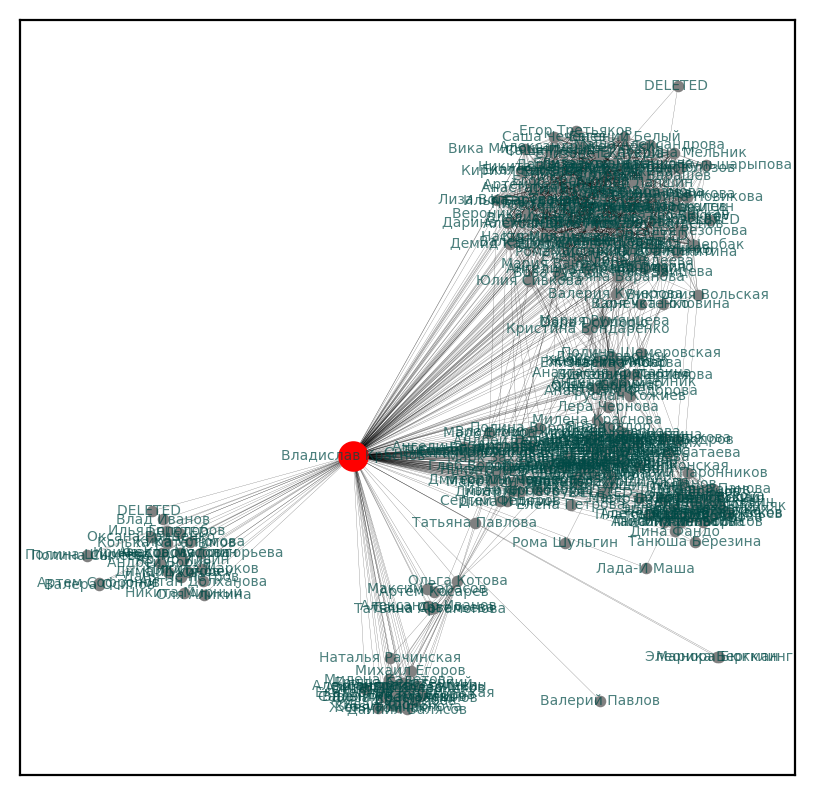

In [32]:
figure(figsize=(5,5), dpi=200)
positions = forceatlas2.forceatlas2_networkx_layout(g, pos=None, iterations=2000)
nx.draw_networkx_nodes(g, positions, node_size=10, node_color="gray")
nx.draw_networkx_nodes(g, positions, node_size=100, nodelist=[ego], node_color="red")
nx.draw_networkx_edges(g, positions, edge_color="black", alpha=0.6, width=0.1)
nx.draw_networkx_labels(g, positions, labels=labels, font_size=5, font_color="#004a46", alpha=0.7)
plt.show()

In [33]:
# pr = nx.pagerank(g, alpha=0.9)

## Генетический алгоритм выделения сообществ

### Инициализация индивидов

Инициализация начальных индивидов популяции происходит следующим образом. Берётся первая вершина графа, затем чтобы был создан "безопасный" индивид (чтобы существовала связь между вершинами) необходимо сгенерировать случайную вершину, которая в матрицы смежности даёт значение 1, затем случайно сгенерированную вершину мы добавляем в список, после чего проделать данную процедуру $N$ раз, где $N$ $-$ количество вершин. Таким образом, на выходе получается список из $N$ генов индивида.

In [34]:
def initialization(adj_matrix: List[List[int]]) -> List[int]:
    nodes_len = len(adj_matrix)
    individual = []

    for i in range(nodes_len):
        rand = random.randint(0, nodes_len-1)
        while adj_matrix[i][rand] != 1:
            rand = random.randint(0, nodes_len-1)
        individual.append(rand)
    
    return individual

In [35]:
individual = initialization(get_adj_matrix(adj_list))

In [36]:
print(individual)

[74, 237, 39, 92, 66, 8, 132, 166, 132, 43, 74, 172, 144, 132, 130, 199, 67, 168, 163, 187, 57, 104, 74, 132, 132, 37, 117, 34, 248, 232, 132, 132, 132, 132, 201, 186, 224, 180, 66, 132, 126, 232, 12, 215, 238, 202, 132, 132, 196, 132, 243, 232, 141, 243, 132, 62, 137, 236, 243, 132, 132, 36, 8, 132, 132, 222, 214, 98, 243, 130, 202, 171, 20, 132, 193, 99, 132, 53, 139, 132, 238, 242, 132, 127, 132, 187, 132, 130, 45, 130, 132, 89, 40, 238, 132, 187, 195, 238, 204, 75, 204, 5, 187, 9, 115, 187, 27, 215, 132, 130, 12, 171, 18, 22, 248, 20, 95, 232, 132, 132, 132, 110, 159, 216, 56, 96, 71, 88, 22, 115, 125, 144, 25, 171, 198, 132, 68, 124, 152, 165, 248, 132, 117, 215, 72, 132, 78, 10, 215, 249, 133, 15, 132, 169, 132, 55, 134, 36, 186, 213, 72, 17, 121, 187, 238, 139, 199, 75, 36, 36, 132, 88, 132, 187, 119, 132, 132, 132, 132, 132, 37, 55, 72, 132, 141, 230, 35, 226, 116, 187, 48, 70, 222, 115, 133, 109, 132, 117, 132, 236, 238, 109, 111, 238, 203, 187, 132, 22, 110, 113, 83, 132, 249

### Создание разбиений подмножеств

После того как мы сгенерировали индивида, для него необходимо найти "безопасное" разбиение на подмножества. Сначала мы генерируем исходный список разбиений как пару $\{i, g_i\} \; | \; \forall i \in \{1,...,N\}$, затем мы объединяем два множества, которые удовлетворяют условию, что существует хотя бы один элемент из пересечения этих множеств. Таким образом, мы проделываем это несколько раз и у нас получается список подмножеств, в которых содержатся все вершины исходного графа.

In [37]:
def merge_subsets(subsets: List[Set[int]]) -> List[Set[int]]:
    result, skip = [], []
    for sub in subsets:
        if sub not in skip:
            new = sub
            for x in subsets:
                if sub & x:
                    new = new | x
                    skip.append(x)
            result.append(new)
    return result

In [38]:
def generate_subsets(individual: List[int]) -> List[Set[int]]:
    sub = [{x, individual[x]} for x in range(len(individual))]
    result = sub
    i = 0
    while i < len(result):
        candidate = merge_subsets(result)
        if candidate == result:
            break
        result = candidate
        i += 1
    return result

In [39]:
print(sorted(individual))

[2, 5, 8, 8, 9, 10, 11, 12, 12, 15, 17, 17, 18, 20, 20, 22, 22, 22, 22, 25, 27, 34, 35, 36, 36, 36, 36, 36, 37, 37, 39, 40, 42, 43, 45, 48, 53, 55, 55, 56, 57, 58, 62, 66, 66, 67, 68, 70, 71, 72, 72, 72, 74, 74, 74, 74, 75, 75, 78, 83, 88, 88, 89, 92, 95, 96, 98, 98, 99, 104, 109, 109, 110, 110, 111, 113, 114, 115, 115, 115, 115, 116, 117, 117, 117, 119, 121, 124, 125, 126, 127, 130, 130, 130, 130, 130, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 134, 136, 137, 139, 139, 141, 141, 144, 144, 148, 151, 152, 159, 163, 165, 166, 168, 168, 168, 168, 168, 169, 169, 171, 171, 171, 172, 180, 186, 186, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 193, 195, 196, 198, 199, 199, 201, 202, 202, 202, 203, 204, 204, 213, 214, 215, 215, 215, 215, 215, 216

In [40]:
print(generate_subsets(individual))

[{0, 3, 4, 7, 10, 12, 15, 20, 21, 22, 38, 40, 42, 45, 57, 66, 70, 71, 72, 74, 83, 88, 92, 104, 110, 111, 113, 115, 121, 126, 127, 128, 129, 131, 133, 144, 147, 149, 150, 151, 160, 162, 166, 171, 182, 191, 193, 194, 199, 202, 207, 208, 209, 210, 212, 214, 219, 227, 234, 236, 239, 246, 249}, {1, 2, 5, 6, 8, 11, 13, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 37, 39, 41, 46, 47, 48, 49, 51, 52, 54, 55, 59, 60, 62, 63, 64, 73, 76, 79, 82, 84, 86, 90, 94, 101, 108, 114, 117, 118, 119, 120, 132, 134, 135, 138, 140, 141, 142, 145, 152, 154, 155, 156, 170, 172, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 190, 196, 197, 198, 206, 211, 217, 218, 220, 223, 225, 228, 229, 230, 232, 237, 244, 245, 247, 248, 251}, {9, 16, 17, 18, 19, 36, 43, 44, 61, 65, 67, 80, 81, 85, 93, 95, 97, 98, 100, 102, 103, 105, 107, 112, 116, 122, 123, 143, 148, 153, 157, 159, 161, 163, 164, 168, 169, 173, 187, 188, 189, 192, 200, 203, 204, 205, 213, 215, 216, 221, 222, 224, 226, 231, 233, 238, 240, 242}, {96, 130, 

### Фитнес функция (Community Score)

Далее мы можем посчитать значение фитнес функции для индивида. Для начала мы создаём подматрицу исходной матрицы смежности $-$ $A$ на основе разбиений. То есть мы генерируем нулевую квадратную матрицу $N \times N$ и заполняем её значениями матрицы смежности только тех вершин, которые находятся в конкретном подмножестве. Далее по формулам мы рассчитываем объём, среднее значение строки, среднее значение мощности подматрицы порядка $r$ и наконец вычисляем значение фитнес функции (Community Score) для данного индивида.

In [41]:
def community_score(individual: List[int], subsets: List[Set[int]], r: float, adj_matrix: List[List[int]]) -> int:
    n = len(individual)
    fitness_value = 0
    for sub in subsets:
        submatrix = [[0 for _ in range(n)] for _ in range(n)]
        for i in sub:
            for j in sub:
                submatrix[i][j] = adj_matrix[i][j]
        volume, M = 0, 0
        for row in list(sub):
            row_mean = sum(submatrix[row])/len(sub)
            M += (row_mean**r)/len(sub)
            volume += sum(submatrix[row])
        fitness_value += M * volume
    return fitness_value

### Отбор

На данный этап проходят все индивиды, которые не являются элитными, это было решено сделать, чтобы не потерять решение и улучшить сходимость алгоритма. Отбор осуществляется правилом рулетки (отбор пропорциональной приспособленности). То есть мы рассчитываем приспособленность каждого индивида, далее находим соотвествующую ему долю и с заданными долями "раскручиваем" рулетку несколько раз, тем самым отбирая нужное количество индивидов. Получается, что чем больше доля приспособленности индивида, тем больше его вероятность пройти отбор.

In [42]:
def roulette_selection(residual: Dict[int, int]) -> int:
    prob = random.random()
    sum_cs = sum(residual.values())
    x = 0
    for k, v in residual.items():
        x += v
        frac = x/sum_cs
        if prob < frac:
            chosen = k
            break
    return chosen

### Скрещивание

Если нужно осуществить скрещивание, то мы с вероятностью 50% ставим либо ген первого родителя, либо ген второго родителя в ребёнка. Если же скрещивание не осуществляется, то мы выбираем одного из родителей, случайным образом.

In [43]:
def uniform_crossover(parent1: List[int], parent2: List[int], crossover_rate: float) -> List[int]:
    if random.random() < crossover_rate:
        length = len(parent1)
        mask = [random.randint(0, 1) for _ in range(length)]
        child = [parent1[i] if mask[i] else parent2[i] for i in range(length)]
        return child
    else:
        return random.choice([parent1, parent2])

### Мутация

Мутация осуществляется с заданной вероятностью следующим образом. Для начала мы генерируем случайную вершину из исходного графа, далее мы отбираем всех соседей данной вершины. После чего случайным образом выбираем соседа в списке всех соседей вершины и меняем ген индивида, на позиции случайной вершины и вставляем на это место случайного соседа данной вершины. Тем самым мы обеспечиваем безопасную мутацию, так как связь сохраняется.

In [44]:
def mutation(individual: List[int], adj_matrix: List[List[int]], mutation_rate: float) -> List[int]:
    if random.random() < mutation_rate:
        individual = deepcopy(individual)
        neighbor = []
        while len(neighbor) < 2:
            mut = random.randint(0, len(individual)-1)
            row = adj_matrix[mut]
            neighbor = [i for i in range(len(row)) if row[i] == 1]
            if len(neighbor) > 1:
                change = random.choice(neighbor)
                individual[mut] = change
    return individual

### Поиск сообществ

После чего, объединяя все вышеперечисленные функции мы можем осуществить алгоритм поиска сообществ.

In [66]:
def community_detection(adj_list: Dict[int, List[int]], *,
                        population_count=300, generation=100,
                        r=3, crossover_rate=0.8, mutation_rate=0.2, elite_reproduction=0.1) -> Dict[str, Union[List[List[int]], Tuple[Union[int, float]]]]:
    
    nodes = get_nodes(adj_list)
    n = len(nodes)
    codes = dict(zip(range(n), nodes))
    adj_matrix = get_adj_matrix(adj_list)
    elites_count = int(math.floor(population_count*elite_reproduction))
    population = [initialization(adj_matrix) for _ in range(population_count)]
    
    for g in range(generation):
        subsets = list(map(generate_subsets, population))
        cs_values = {i: community_score(population[i], subsets[i], r, adj_matrix) for i in range(population_count)}
        elites = dict(sorted(cs_values.items(), key=lambda item: -item[1])[:elites_count]).keys()
        residual = dict(sorted(cs_values.items(), key=lambda item: -item[1])[elites_count:])
        new_population = [population[i] for i in elites]
        for i in range(population_count-elites_count):
            p1 = roulette_selection(residual)
            p2 = roulette_selection(residual)
            parent1, parent2 = population[p1], population[p2]
            child = uniform_crossover(parent1, parent2, crossover_rate)
            child = mutation(child, adj_matrix, mutation_rate)
            new_population.append(child)
        population = new_population
    
    subsets = list(map(generate_subsets, population))
    cs_values = {i: community_score(population[i], subsets[i], r, adj_matrix) for i in range(population_count)}

    best = sorted(cs_values.items(), key=lambda item: -item[1])[0]
    node_subs = generate_subsets(population[i])
    res = [[codes[node] for node in sub] for sub in node_subs]
    return {"communities": res, "best_individual": best}

In [67]:
res = community_detection(adj_list)

In [68]:
print(res["communities"])

[[195855874, 74240009, 176500751, 124785171, 85755427, 192837173, 158916153, 239993407, 84889677, 41392216, 172904030, 9905767, 192831093, 157292179, 146369173, 121616031, 108898977, 155480739, 37223600, 5244089, 348622515, 275744443, 257070268, 426326199, 166905034, 131887844, 71266537, 234432233, 195011310, 311798004, 126592268, 52185873, 216463633, 272017171, 41374484, 150905621, 167951126, 97272599, 104155935, 242285865, 370595118, 171178802, 40596275, 55580467, 150498615, 225091894, 183443782, 236927821, 322477391, 123030870, 91390312, 132990321, 447019391, 32727429, 389706630, 168916871, 36936072, 174200717, 20855183, 9513362, 333117349, 173453222, 51754421, 131350469, 38532040, 189158358, 37890018, 139118052, 67313644, 39426549, 56905721], [164406275, 165610793, 342331930, 261104941, 174680691, 219750976, 16363269, 38703427, 379432913, 300500557, 450042842, 212956, 145693525, 354199011, 140840285, 123088112, 157837814, 150794609, 172422515, 158395150], [30767109, 5758677, 156082

In [69]:
print(res["best_individual"])

(0, 439.12674231641296)


In [70]:
len(res["communities"])

9

### Визуализация результата

In [71]:
def generate_color(num: int) -> List[str]:
    return ["#" + "".join([random.choice("0123456789ABCDEF") for _ in range(6)]) for _ in range(num)]

In [72]:
def draw_communities(g: nx.Graph, communities: List[List[int]], forceatlas2_params: ForceAtlas2) -> None:
    figure(figsize=(5,5), dpi=200)
    positions = forceatlas2.forceatlas2_networkx_layout(g, pos=None, iterations=2000)
    k = len(communities)
    colors = generate_color(k)
    for i in range(k):
        nx.draw_networkx_nodes(g, positions, node_size=10, nodelist=communities[i], node_color=colors[i])
    nx.draw_networkx_nodes(g, positions, node_size=100, nodelist=[ego], node_color="red")
    nx.draw_networkx_edges(g, positions, edge_color="black", alpha=0.6, width=0.1)
    nx.draw_networkx_labels(g, positions, labels=labels, font_size=5, font_color="#004a46", alpha=0.7)
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1184.23it/s]


BarnesHut Approximation  took  0.48  seconds
Repulsion forces  took  0.98  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


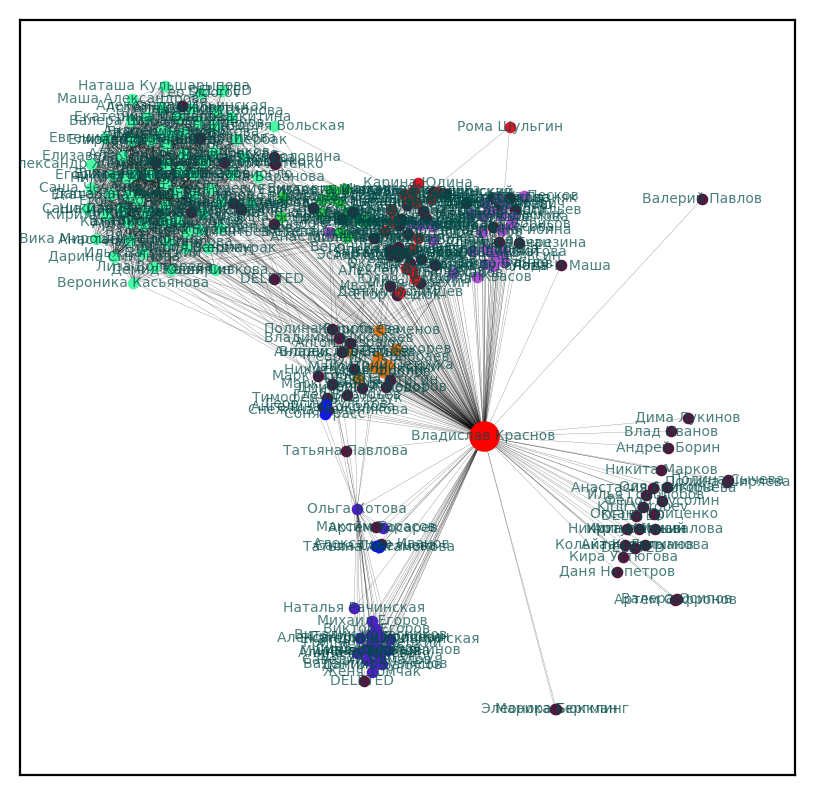

In [73]:
draw_communities(g, res["communities"], forceatlas2)

## Алгоритм Ньюмена-Гирвана

Функция `high_edge_betweenness` определяет ребро с самой высокой степенью посредничества.

In [53]:
def high_edge_betweenness(G: nx.Graph) -> Tuple[int]:
    edge_betweenness = nx.edge_betweenness_centrality(G)
    sorted_edges = list(sorted(edge_betweenness.items(), key=lambda x: -x[1]))
    return sorted_edges[0][0]

In [54]:
def newman_girvan(G: nx.Graph) -> List[Set[int]]:
    graph = deepcopy(G)
    components = list(nx.connected_components(graph))
    mod = nx.algorithms.community.modularity(graph, components)
    new_mod, old_mod = mod, mod
    
    while new_mod >= old_mod:
        graph.remove_edge(*high_edge_betweenness(graph))
        components = list(nx.connected_components(graph))
        old_mod = new_mod
        new_mod = nx.algorithms.community.modularity(graph, components)
    return list(map(list, components))

In [55]:
g = nx.Graph(adj_list)

In [56]:
res = newman_girvan(g)

In [57]:
print(res)

[[195855874, 74240009, 176500751, 124785171, 56835615, 85755427, 192837173, 136865335, 158916153, 239993407, 84889677, 41392216, 172904030, 9905767, 291481709, 192831093, 157292179, 146369173, 121616031, 108898977, 155480739, 37223600, 268490931, 348622515, 162466483, 426326199, 5244089, 275744443, 257070268, 166905034, 296882403, 131887844, 71266537, 234432233, 182549738, 195011310, 311798004, 126592268, 52185873, 216463633, 272017171, 41374484, 150905621, 167951126, 97272599, 53849374, 104155935, 242285865, 388051245, 370595118, 171178802, 40596275, 55580467, 225091894, 150498615, 183443782, 236927821, 322477391, 123030870, 91390312, 132990321, 447019391, 296991104, 32727429, 389706630, 168916871, 36936072, 174200717, 20855183, 9513362, 333117349, 173453222, 51754421, 131350469, 38532040, 189158358, 37890018, 139118052, 67313644, 39426549, 56905721], [98164570, 199718427, 6762342], [156461954, 33531657, 95068810, 170618897, 230320171, 138203440, 159238451, 23271603, 64240955, 9460652

In [58]:
print(len(res))

46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1178.23it/s]


BarnesHut Approximation  took  0.45  seconds
Repulsion forces  took  1.02  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


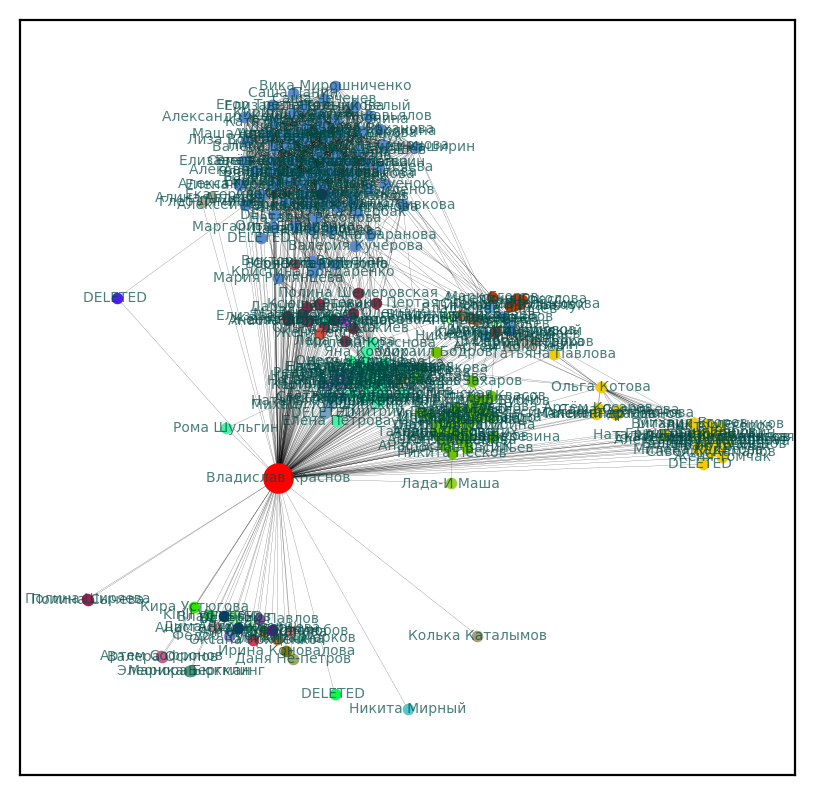

In [59]:
draw_communities(g, res, forceatlas2)

### Анализ гиперпараметров

In [60]:
with open("result.json", "r") as f:
    params = json.load(f)
    
params = list({eval(k): v for k, v in params.items()}.items())

In [61]:
fitness_value = {i: params[i][1]["best_individual"][1] for i in range(len(params))}

In [62]:
fitness_value

{0: 780.2031424752183,
 1: 795.5587675084621,
 2: 700.8731078184863,
 3: 919.6190449692626,
 4: 824.5568924642857,
 5: 811.3844033145788,
 6: 895.8662741304162,
 7: 999.3353359753771,
 8: 794.3187963786154,
 9: 831.5210676402179,
 10: 1020.9826109907214,
 11: 785.1520396749922,
 12: 888.8933408009855,
 13: 922.454269627817,
 14: 1007.1991533151531,
 15: 869.3148902493506,
 16: 862.0659509668375,
 17: 847.5922687681115,
 18: 954.495638981806,
 19: 849.5330476934406,
 20: 726.8690642781537,
 21: 885.7712373072867,
 22: 970.0433584498945,
 23: 935.6399425538491}

In [63]:
max_fitness = max(fitness_value, key=fitness_value.get)
print(max_fitness)

10


In [64]:
args = params[max_fitness][0]
comm = params[max_fitness][1]["communities"]
print(args)

(400, 30, 0.8, 0.2)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1265.78it/s]


BarnesHut Approximation  took  0.44  seconds
Repulsion forces  took  0.91  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


NetworkXError: Node 247495172 has no position.

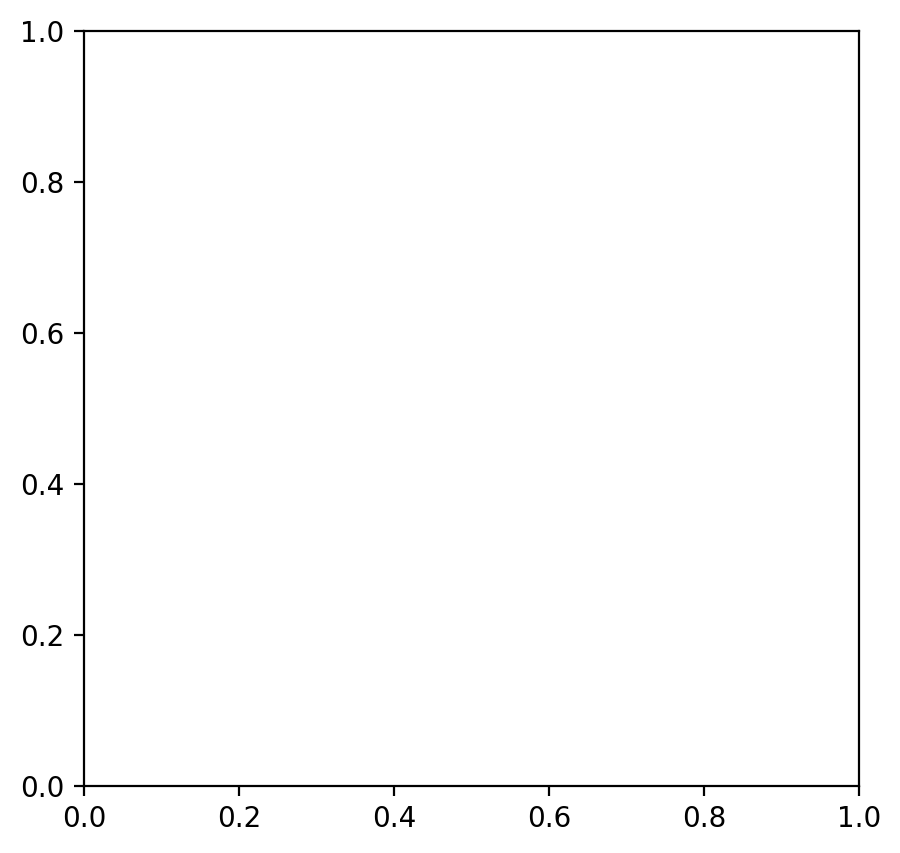

In [65]:
draw_communities(g, comm, forceatlas2)